### Step 1: Retrieve homologs of Gloeobacter rhodopsin (GR)

To identify homologs of **Gloeobacter rhodopsin (GR)**, I ran a BLASTp search against the UniRef90 database using the  
[`scripts/blast_uniref.py`](../scripts/blast_uniref.py) helper script.

- Query: `data/GR.fasta` (accession BAC88139.1)
- Database: UniRef90
- Program: BLASTp
- Date run: 2025-08-22
- Top hits retained: 150
- Output: `data/BAC88139.1_top150_uniref90.fasta`

This was executed once on 2025-08-22 to generate results for downstream analysis.  
To avoid hitting EBI servers repeatedly, the script call is documented below but not re-executed.

Later - removed 3 sequences from the file that were missing the first transmembrane domain (UPI0035935AE6, AOA2P8WHZ5, UPI001C63F925) because they're likely incomplete genes and wouldn't form a functional protein. 

In [5]:
from pathlib import Path
from datetime import datetime

#Run ID to be used for naming output files
RUN_ID = datetime.now().strftime("%Y%m%d")
RUNID_DASH = datetime.now().strftime("%Y-%m-%d")

RUN_ID = "20250827"
RUNID_DASH = "2025-08-27"


#Define paths for current project
# --- Centralized paths ---
ROOT = Path("..")
DATA = ROOT / "data"
LOGS = ROOT / "logs"
SCRIPTS = ROOT / "scripts"
RESULTS = ROOT / "results"
ALIGN_DIR = RESULTS / "align"
TREE_DIR = RESULTS / "trees"
FIGURES = RESULTS / "figures"

# --- Key files ---
GR_FASTA = DATA / "GR.fasta" #Starting file for BLAST search 
BLAST_OUT = DATA / "BAC88139.1_top150_uniref90.fasta"
RENAMED_FASTA = DATA / "BAC88139.1_top150_uniref90.rename.fasta"

CULLED_FASTA = DATA / f"BAC88139.1_top150_uniref90.rename.culled_{RUN_ID}.fasta"
DISCARDED_FASTA = DATA / f"BAC88139.1_top150_uniref90.rename.discarded_{RUN_ID}.fasta"
SUMMARY_CSV = LOGS / f"GR_max_similarity_{RUN_ID}.csv"

# --- Alignment and tree output ---
ALIGN_DIR.mkdir(parents=True, exist_ok=True)
TREE_DIR.mkdir(parents=True, exist_ok=True)
ALN_FASTA = ALIGN_DIR / f"BAC88139.1_top150_uniref90.rename.culled_{RUN_ID}_ALN.faa"
IQ_PREFIX = TREE_DIR / f"BAC88139.1_top150_uniref90.rename.culled_{RUN_ID}_ML_{RUNID_DASH}"

#Uniref analysis on knot to find diverse rhodopsins
ALL_UNIREF_HITS = DATA / "All_uniref50_hits.fa"  # Concatenated microbial rhodopsin hits from knot analysis




| Gene name                        | Species                                              | λmax (nm) | GenBank protein accession | Source reference                                 |
|-----------------------------------|-----------------------------------------------------|-----------|--------------------------|--------------------------------------------------|
| Y_CyRII_P7104R                   | Nodosilinea nodulosa PCC 7104                       | 570       | WP_017301364.1           | Hasegawa-Takano et al. 2024 (ISME J)             |
| BR (Bacteriorhodopsin)           | Halobacterium salinarum                             | 570       | WP_136361479.1           | Oesterhelt & Stoeckenius 1971; Lozier et al. 1975|
| N2098R                           | Calothrix sp. NIES-2098                             | 550       | BAY09002.1               | Hasegawa et al. 2020 (Sci Rep)                   |
| GR (Gloeobacter rhodopsin)       | Gloeobacter violaceus PCC 7421                      | 544       | WP_011140202.1           | Choi et al. 2014 (PLoS ONE)                      |
| PR (GPR, green proteorhodopsin)  | Uncultivated marine γ-proteobacterium (SAR86; EBAC31A08) | 520   | AAG10475.1               | Béjà et al. 2000 (Science)                       |
| PR (BPR, blue proteorhodopsin)   | Marine bacterioplankton (HOT75m4 variant)           | 490       | Q9AFF7.2                 | Béjà et al. 2001 (Nature)                        |

In [6]:
#Download BAIT sequences
from Bio import Entrez

Entrez.email = "oakley@ucsb.edu"

accessions = [
    "WP_017301364.1",
    "WP_136361479.1",
    "BAY09002.1",
    "WP_011140202.1",
    "AAG10475.1",
    "Q9AFF7.2"
]

output_fasta = DATA / "bait.fasta"

with open(output_fasta, "w") as out_handle:
    for acc in accessions:
        try:
            handle = Entrez.efetch(db="protein", id=acc, rettype="fasta", retmode="text")
            seq = handle.read()
            if seq.strip() and seq.startswith(">"):
                out_handle.write(seq + "\n")
            else:
                print(f"Did not find {acc}")
        except Exception:
            print(f"Did not find {acc}")

print(f"Sequences written to {output_fasta}")

Sequences written to ../data/bait.fasta


In [ ]:
#Using table above as bait, search Uniref and download clost blast hits of Uniref90

#This takes about 50 minutes for a run from scratch

#job_id = "ncbiblast-I20250901-173114-0788-19601246-p1m"
#!python {SCRIPTS / "blast_uniref90.py"} dummy dummy --max_hits 33 --out {DATA / "WP_011140202.1_top33_uniref90.fasta"} --log {LOGS / "WP_011140202.1_blast_runs.log"} --jobid {job_id} --force

from pathlib import Path

# Table of accessions and max_hits. Aiming for 15,15,15,15,30 .. but need to add a few to account for
# later deletions of incomplete sequences

bait_table = [
    ("YCyR2hit", "WP_017301364.1", 15),
    ("BRhit", "WP_136361479.1", 16),
    ("GCyR2hit", "BAY09002.1", 17),
    ("GRhit", "WP_011140202.1", 30),
    #("GPRhit", "AAG10475.1", 10),
    #("BPRhit", "Q9AFF7.2", 10), #BPR and GPR mostly hitting the same genes, just do PR instead
    ("PRhit", "AAG10475.1", 15),
]

run_table = [
    "ncbiblast-R20250902-012715-0963-64586178-p1m", # "BRhit", "WP_136361479.1"
    "ncbiblast-R20250902-014018-0359-36391454-p1m", # GRhit, WP_011140202.1
]

email = "oakley@ucsb.edu"

for _, accession, max_hits in bait_table:
    out_fasta = DATA / f"{accession}_top{max_hits}_uniref90.fasta"
    log_file = LOGS / f"{accession}_blast_runs.log"
    print(f"Running BLAST for {accession} (max_hits={max_hits})")
    !python {SCRIPTS / "blast_uniref90.py"} {accession} {email} --max_hits {max_hits} --out {out_fasta} --log {log_file}

Running BLAST for WP_017301364.1 (max_hits=15)
ERROR: Output file ../data/WP_017301364.1_top15_uniref90.fasta already exists. Use --force to overwrite.
ERROR:root:ERROR: Output file ../data/WP_017301364.1_top15_uniref90.fasta already exists. Use --force to overwrite.
Running BLAST for WP_136361479.1 (max_hits=16)
Fetching sequence for accession: WP_136361479.1
Submitting BLAST for: WP_136361479.1
Job ID: ncbiblast-R20250902-012715-0963-64586178-p1m
[17:27:21] Status: RUNNING
[17:27:29] Status: RUNNING
[17:27:36] Status: RUNNING
[17:27:44] Status: RUNNING
[17:27:51] Status: RUNNING
[17:27:58] Status: RUNNING
[17:28:05] Status: RUNNING
[17:28:13] Status: RUNNING
[17:28:22] Status: RUNNING
[17:28:30] Status: RUNNING
[17:28:37] Status: RUNNING
[17:28:44] Status: RUNNING
[17:28:52] Status: RUNNING
[17:28:59] Status: RUNNING
[17:29:06] Status: RUNNING
[17:29:14] Status: RUNNING
[17:29:22] Status: RUNNING
[17:29:29] Status: RUNNING
[17:29:36] Status: RUNNING
[17:29:43] Status: RUNNING
[17:29:

In [70]:
# Rename the sequences with a common prefix to keep track of them during analyses
bait_table = [
    ("YCyR2hit", "WP_017301364.1", 15),
    ("BRhit", "WP_136361479.1", 16),
    ("GCyR2hit", "BAY09002.1", 17),
    ("GRhit", "WP_011140202.1", 30),
    #("GPRhit", "AAG10475.1", 10),
    #("BPRhit", "Q9AFF7.2", 10), #BPR and GPR mostly hitting the same genes, just do PR instead
    ("PRhit", "AAG10475.1", 15),
]
renamed_files = []

for prefix, accession, max_hits in bait_table:
    blast_out = DATA / f"{accession}_top{max_hits}_uniref90.fasta"
    renamed_fasta = DATA / f"{accession}_top{max_hits}_renamed.fasta"
    renamed_files.append(renamed_fasta)
    print(f"Renaming {blast_out} -> {renamed_fasta} with prefix {prefix}")
    !python {SCRIPTS / "rename_fasta_headers.py"} {blast_out} {renamed_fasta} --prefix {prefix} --force

# Concatenate all renamed FASTA files into one
combined_fasta = DATA / "combined_uniref90.fasta"
with open(combined_fasta, "w") as outfile:
    for fname in renamed_files:
        with open(fname) as infile:
            outfile.write(infile.read())
print(f"Combined all renamed FASTA files into {combined_fasta}")

Renaming ../data/WP_017301364.1_top15_uniref90.fasta -> ../data/WP_017301364.1_top15_renamed.fasta with prefix YCyR2hit
Reformatted 15 headers → ../data/WP_017301364.1_top15_renamed.fasta
Renaming ../data/WP_136361479.1_top16_uniref90.fasta -> ../data/WP_136361479.1_top16_renamed.fasta with prefix BRhit
Reformatted 15 headers → ../data/WP_136361479.1_top16_renamed.fasta
Renaming ../data/BAY09002.1_top17_uniref90.fasta -> ../data/BAY09002.1_top17_renamed.fasta with prefix GCyR2hit
Reformatted 15 headers → ../data/BAY09002.1_top17_renamed.fasta
Renaming ../data/WP_011140202.1_top30_uniref90.fasta -> ../data/WP_011140202.1_top30_renamed.fasta with prefix GRhit
Reformatted 30 headers → ../data/WP_011140202.1_top30_renamed.fasta
Renaming ../data/AAG10475.1_top15_uniref90.fasta -> ../data/AAG10475.1_top15_renamed.fasta with prefix PRhit
Reformatted 15 headers → ../data/AAG10475.1_top15_renamed.fasta
Combined all renamed FASTA files into ../data/combined_uniref90.fasta


In [ ]:
from pathlib import Path
from Bio import SeqIO

# Input FASTA to filter (update this as needed)
input_fasta = DATA / "combined_uniref90.fasta"  # <-- This is your starting file
CULLED_FASTA = DATA / "pumphits_culled.fasta"  # Output after removing sequences

# List of sequence IDs to remove (exact matches)
remove_ids = [
    "BRhit__Halobacterium_salinarum__UniRef90_UPI0000110B77",
    "GRhit__Chamaesiphon_sp__UniRef90_UPI0035935AE6",
    "GCyR2hit__Pseudanabaenaceae_cyanobacterium_LEGE_13415__UniRef90_A0A928YZN9",
    "GRhit__Chamaesiphon_sp__UniRef90_UPI0035946169",
]

def normalize_id(s):
    # Remove quotes, whitespace, tabs, and collapse all spaces
    return "".join(s.strip().strip('"').strip("'").split())

remove_ids_normalized = set(normalize_id(x) for x in remove_ids)

# Remove listed sequences and write culled FASTA
records = []
removed_count = 0
with open(input_fasta) as in_handle:
    for record in SeqIO.parse(in_handle, "fasta"):
        rec_id_norm = normalize_id(record.id)
        if rec_id_norm not in remove_ids_normalized:
            records.append(record)
        else:
            print(f"Removed: {record.id!r} (normalized: {rec_id_norm!r})")
            removed_count += 1

with open(CULLED_FASTA, "w") as out_handle:
    SeqIO.write(records, out_handle, "fasta")

print(f"Filtered FASTA written to {CULLED_FASTA}")
print(f"Total sequences removed: {removed_count}")
print(f"Total unique sequences retained: {len(records)}")

# Align with MAFFT
ALN_FASTA = ALIGN_DIR / "pumphits_ALN.fasta"
!mafft --auto --thread -1 --quiet "{CULLED_FASTA}" > "{ALN_FASTA}"
print("Aligned ->", ALN_FASTA)

# Build a maximum likelihood tree with IQ-TREE2
IQ_PREFIX = TREE_DIR / "pumphits_iqtree"
!iqtree2 -s "{ALN_FASTA}" -m LG+F+R4 -nt AUTO -keep-ident -pre "{IQ_PREFIX}" -quiet -redo

Removed: 'BRhit__Halobacterium_salinarum__UniRef90_UPI0000110B77' (normalized: 'BRhit__Halobacterium_salinarum__UniRef90_UPI0000110B77')
Removed: 'GCyR2hit__Pseudanabaenaceae_cyanobacterium_LEGE_13415__UniRef90_A0A928YZN9' (normalized: 'GCyR2hit__Pseudanabaenaceae_cyanobacterium_LEGE_13415__UniRef90_A0A928YZN9')
Removed: 'GRhit__Chamaesiphon_sp__UniRef90_UPI0035946169' (normalized: 'GRhit__Chamaesiphon_sp__UniRef90_UPI0035946169')
Removed: 'GRhit__Chamaesiphon_sp__UniRef90_UPI0035935AE6' (normalized: 'GRhit__Chamaesiphon_sp__UniRef90_UPI0035935AE6')
Filtered FASTA written to ../data/pumphits_culled.fasta
Total sequences removed: 4
Aligned -> ../results/align/pumphits_ALN.fasta


Saved tree figure to: ../results/figures/pumphits_iqtree_tree.pdf


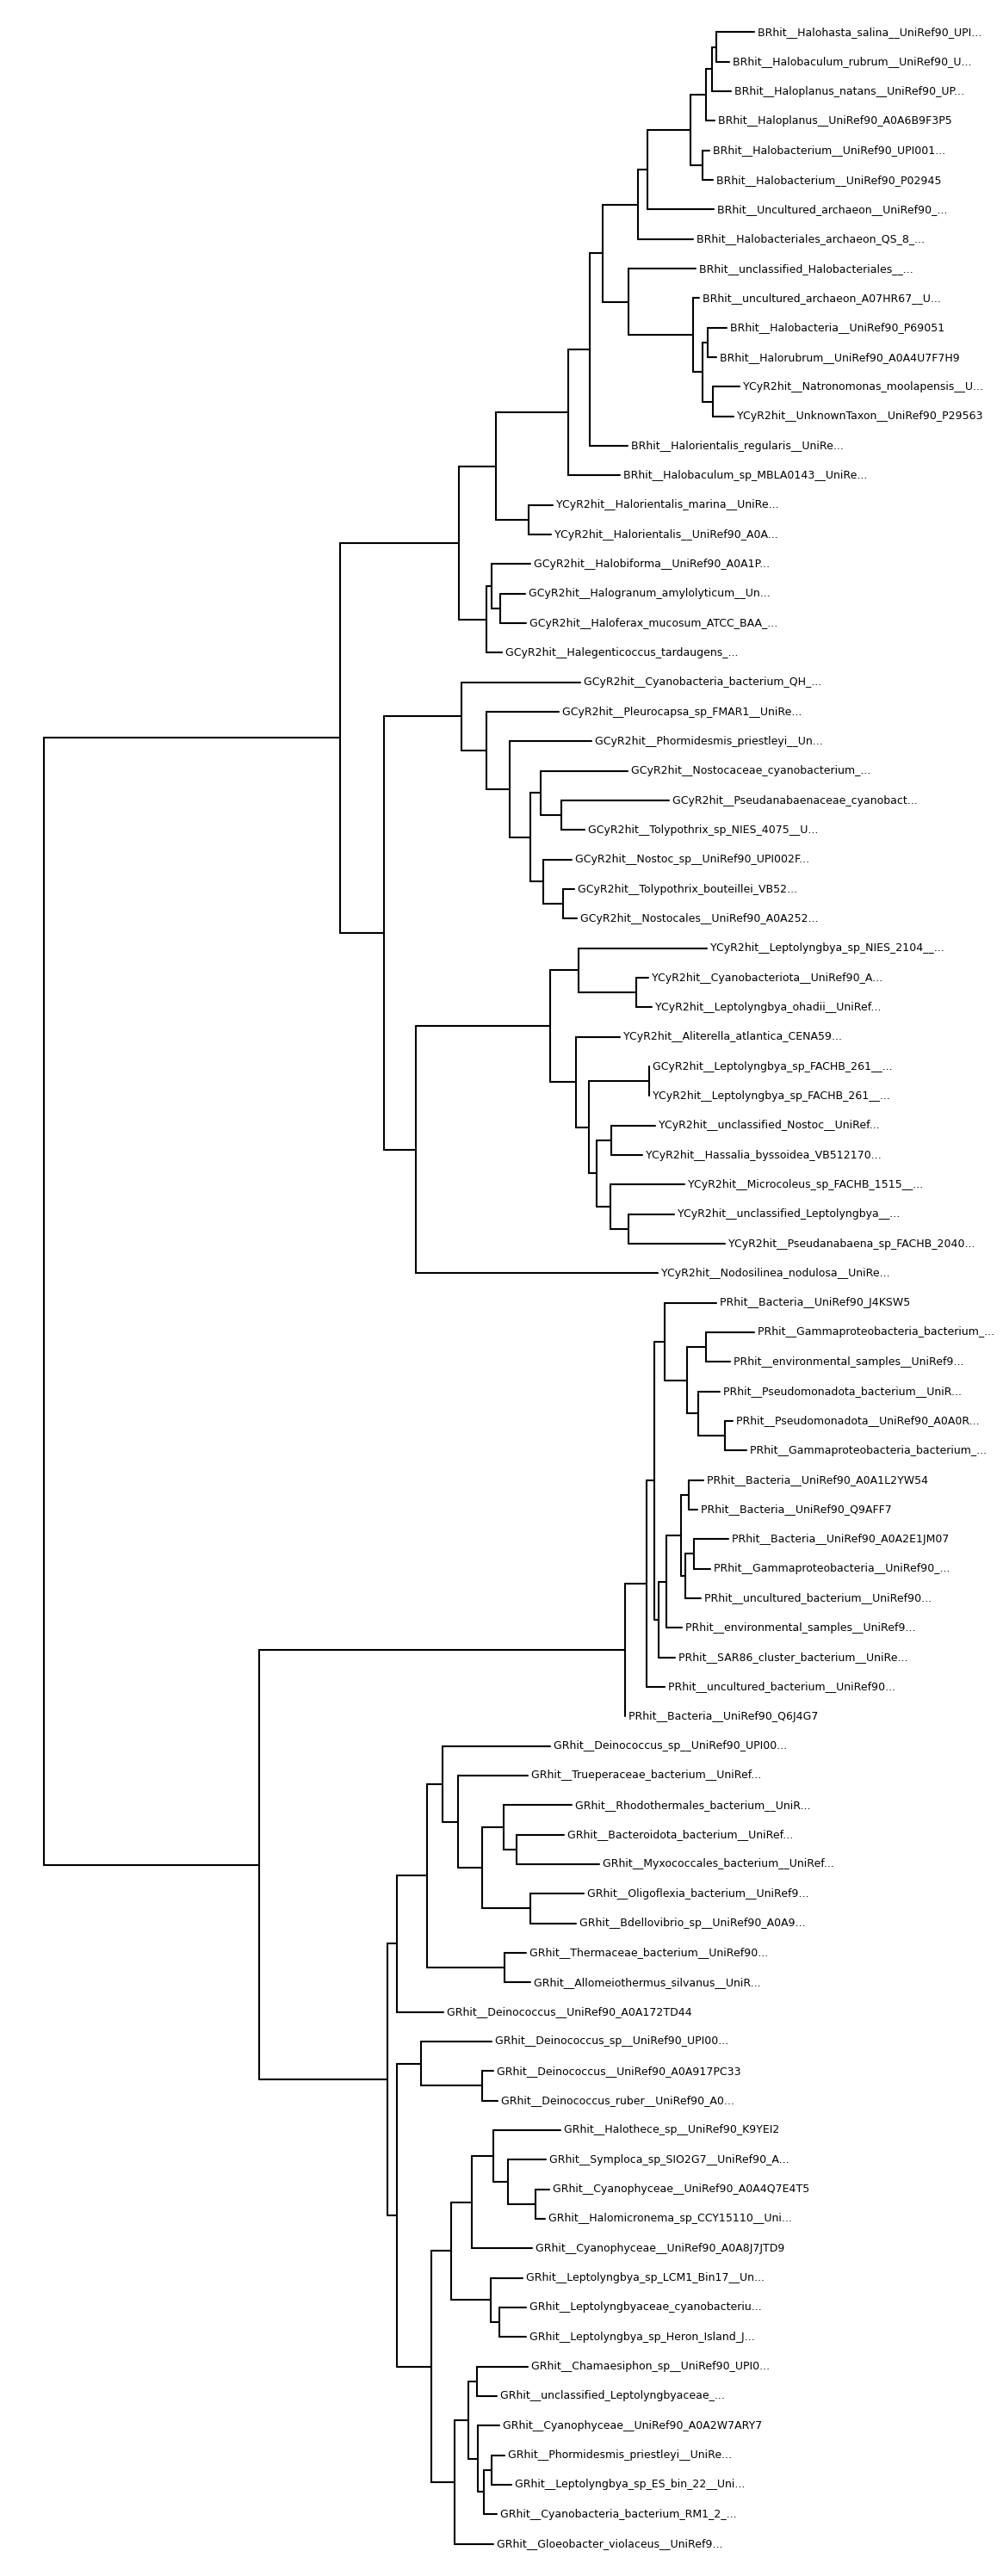

In [72]:
from pathlib import Path

# Set IQ_PREFIX so output files go into TREE_DIR
IQ_PREFIX = TREE_DIR / "pumphits_iqtree"

# IQ-TREE2 command (in shell, use -pre "{IQ_PREFIX}" to ensure output goes to TREE_DIR)
# !iqtree2 -s "{ALN_FASTA}" -m LG+F+R4 -nt AUTO -keep-ident -pre "{IQ_PREFIX}" -quiet

# In Python, use IQ_PREFIX for downstream file paths
tree_file = IQ_PREFIX.with_suffix(".treefile")
fig_path = FIGURES / f"{IQ_PREFIX.name}_tree.pdf"

plot_tree(tree_file, save_path=fig_path, figsize=(12, 30))


In [ ]:
from pathlib import Path
from Bio import SeqIO

# Define input files
fasta1 = DATA / "pumphits_culled.fasta"  # Output after removing sequences
fasta2 = DATA / "hasegawa24" / "rhodopsins_from_accessions.fasta"
combined_fasta = DATA / "combined_plus_hasegawa24.fasta"

# Combine the two FASTA files
with open(combined_fasta, "w") as outfile:
    for fname in [fasta1, fasta2]:
        with open(fname) as infile:
            outfile.write(infile.read())

print(f"Combined FASTA written to {combined_fasta}")

# File to filter
input_fasta = DATA / "combined_plus_hasegawa24.fasta"
output_fasta = DATA / "combined_plus_hasegawa24_culled.fasta"

# List of sequence IDs to remove (exact matches)
remove_ids = [
    "BRhit__Halobacterium_salinarum__UniRef90_UPI0000110B77",
    "GRhit__Chamaesiphon_sp__UniRef90_UPI0035935AE6",
    "GCyR2hit__Pseudanabaenaceae_cyanobacterium_LEGE_13415__UniRef90_A0A928YZN9",
    "GRhit__Chamaesiphon_sp__UniRef90_UPI0035946169",
    "XeR_AFY92621.1",
    "CyR-II_MBV9385464.1",
    #Next is missing conserved lysine
    "XeR_ACL43260.1",    
]

def normalize_id(s):
    # Remove quotes, whitespace, tabs, and collapse all spaces
    return "".join(s.strip().strip('"').strip("'").split())

# Normalize remove_ids for robust matching
remove_ids_normalized = set(normalize_id(x) for x in remove_ids)

# Remove listed sequences and deduplicate by sequence
records = []
removed_count = 0
with open(input_fasta) as in_handle:
    for record in SeqIO.parse(in_handle, "fasta"):
        rec_id_norm = normalize_id(record.id)
        if rec_id_norm not in remove_ids_normalized:
            records.append(record)
        else:
            print(f"Removed: {record.id!r} (normalized: {rec_id_norm!r})")
            removed_count += 1

# Deduplicate by sequence (keep first occurrence)
seq_seen = set()
deduped_records = []
for rec in records:
    seq_str = str(rec.seq)
    if seq_str not in seq_seen:
        deduped_records.append(rec)
        seq_seen.add(seq_str)

with open(output_fasta, "w") as out_handle:
    SeqIO.write(deduped_records, out_handle, "fasta")

print(f"Filtered and deduplicated FASTA written to {output_fasta}")
print(f"Total sequences removed: {removed_count}")
print(f"Total unique sequences retained: {len(deduped_records)}")

# Align with MAFFT
ALN_FASTA = ALIGN_DIR / "combined_plus_hasegawa24_ALN.fasta"
!mafft --auto --thread -1 --quiet "{output_fasta}" > "{ALN_FASTA}"
print("Aligned ->", ALN_FASTA)

# Estimate phylogeny with IQ-TREE2
IQ_PREFIX = TREE_DIR / "combined_plus_hasegawa24_iqtree"
!iqtree2 -s "{ALN_FASTA}" -m LG+F+R4 -nt AUTO -keep-ident -pre "{IQ_PREFIX}" -quiet -redo
print("IQ-TREE2 run complete. Tree files in", TREE_DIR)

Combined FASTA written to ../data/combined_plus_hasegawa24.fasta
Removed: 'XeR_ACL43260.1' (normalized: 'XeR_ACL43260.1')
Removed: 'XeR_AFY92621.1' (normalized: 'XeR_AFY92621.1')
Removed: 'CyR-II_MBV9385464.1' (normalized: 'CyR-II_MBV9385464.1')
Filtered and deduplicated FASTA written to ../data/combined_plus_hasegawa24_culled.fasta
Total sequences removed: 3
Total unique sequences retained: 156
Aligned -> ../results/align/combined_plus_hasegawa24_ALN.fasta


Saved tree figure to: ../results/figures/combined_plus_hasegawa24_iqtree_tree.pdf


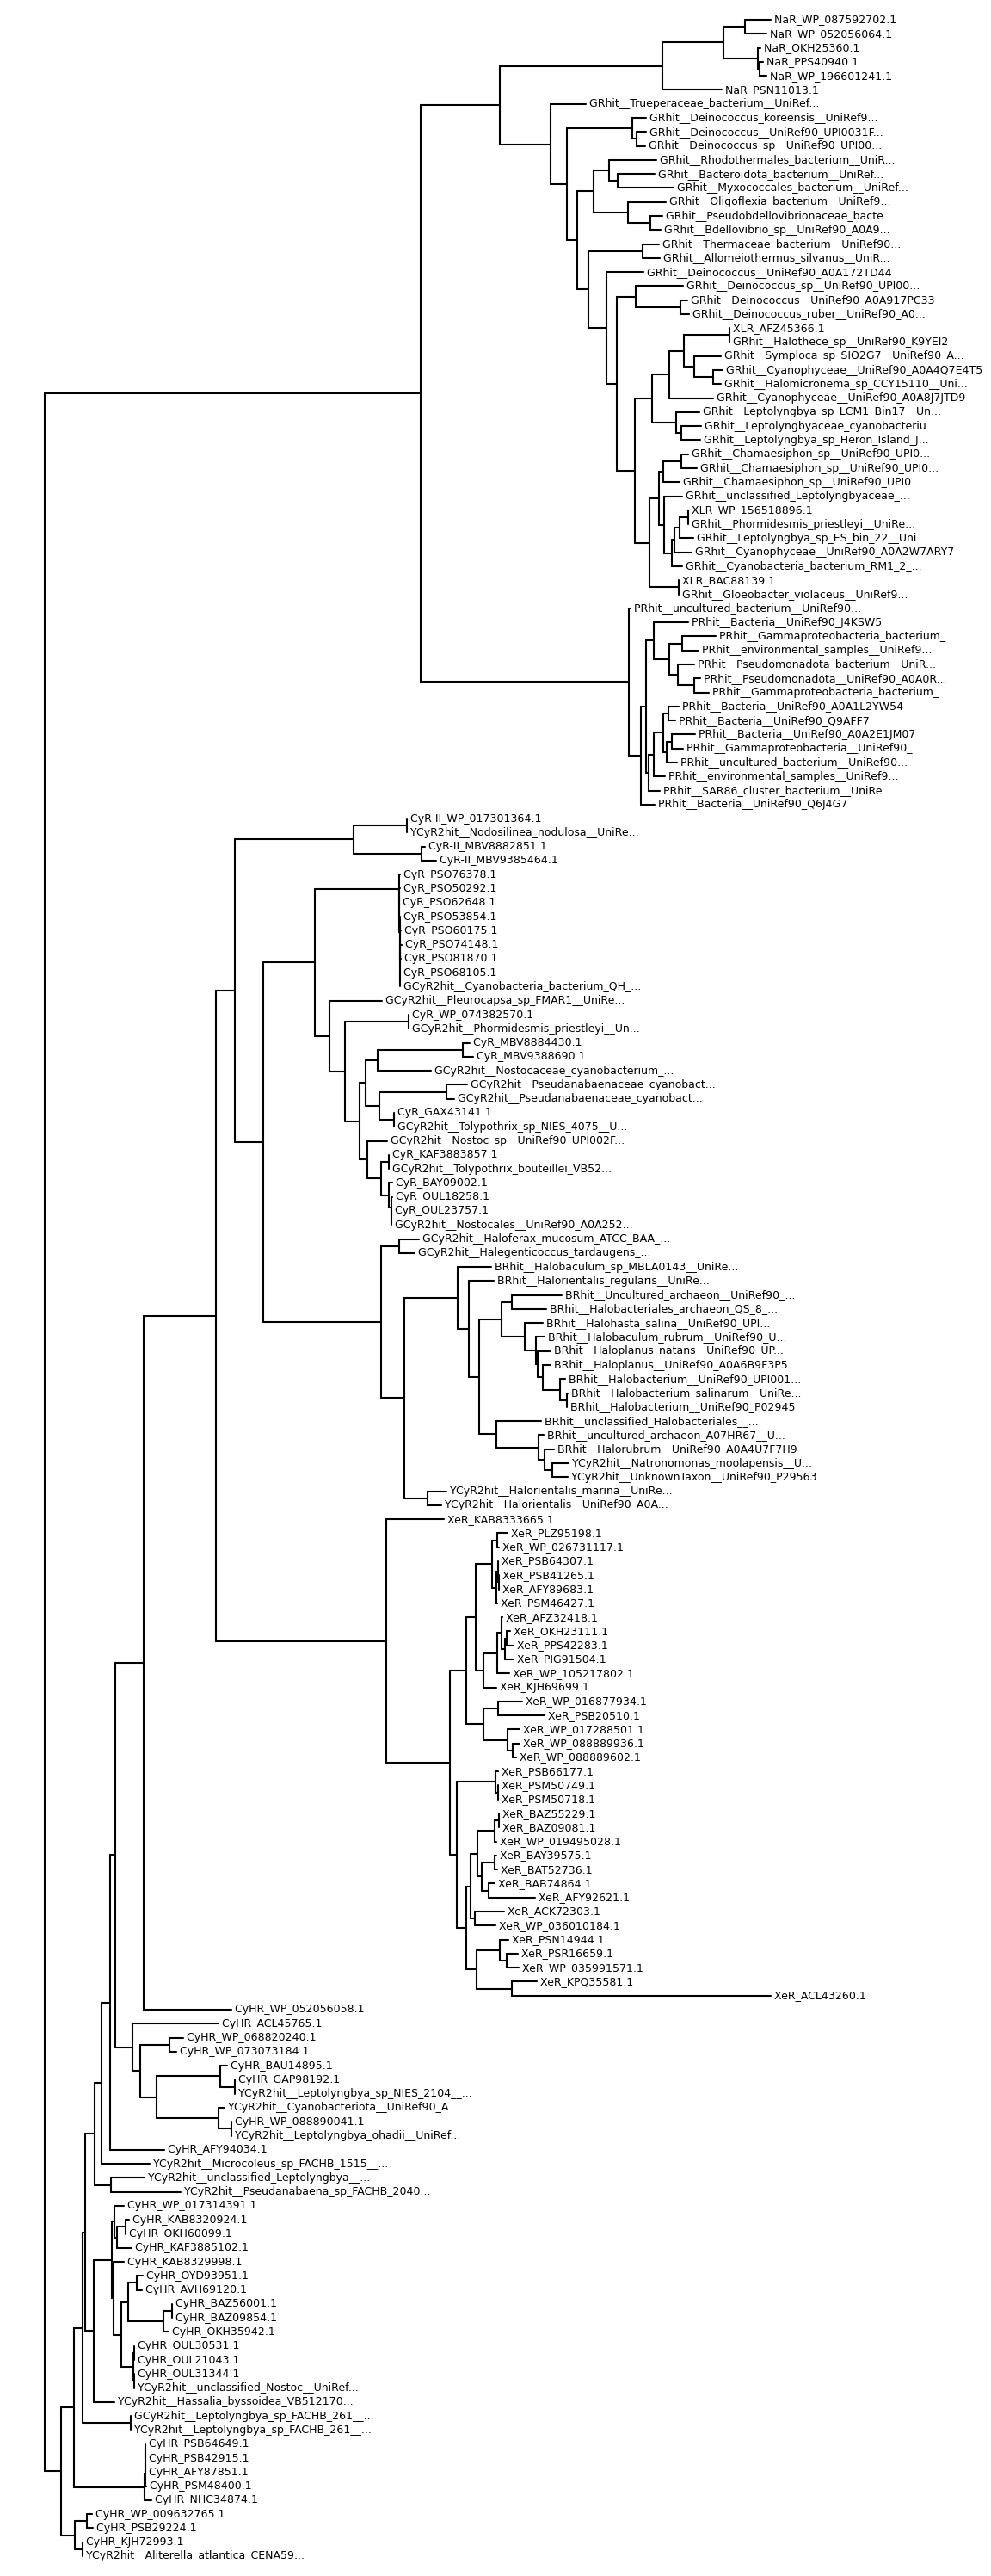

In [55]:
from pathlib import Path

# Set IQ_PREFIX so output files go into TREE_DIR
IQ_PREFIX = TREE_DIR / "combined_plus_hasegawa24_iqtree"

# IQ-TREE2 command (in shell, use -pre "{IQ_PREFIX}" to ensure output goes to TREE_DIR)
# !iqtree2 -s "{ALN_FASTA}" -m LG+F+R4 -nt AUTO -keep-ident -pre "{IQ_PREFIX}" -quiet

# In Python, use IQ_PREFIX for downstream file paths
tree_file = IQ_PREFIX.with_suffix(".treefile")
fig_path = FIGURES / f"{IQ_PREFIX.name}_tree.pdf"

plot_tree(tree_file, save_path=fig_path, figsize=(12, 30))

### Step 2: Identify a diversity of microbial rhodopsins by BLAST similarity to UniRef50

To expand the diversity of microbial rhodopsins, I performed DIAMOND BLASTp searches against a local copy of UniRef50 on the `knot` server at CNSI at UCSB. 
This step was done outside this repository due to the size of UniRef50 and compute requirements.


#### **Original bait FASTA files used for BLAST searches**

The following FASTA files were used as queries ("baits") for DIAMOND BLASTp searches against UniRef50.  
Each file contains a representative opsin gene from a diverse set of microbial lineages:

| Filename         | Accession         | Species/Strain                              | Description                        |
|------------------|-------------------|---------------------------------------------|------------------------------------|
| **BR_Halobacterium.fasta** | CAP14056.1        | Halobacterium salinarum R1                  | bacteriorhodopsin                  |
| **CyHR_Mastigocladopsis.fasta** | WP_017314391.1    | Mastigocladopsis repens                      | bacteriorhodopsin                  |
| **CyHR_Synechocystis.fasta** | WP_009632765.1    | Synechocystis sp. PCC 7509                   | bacteriorhodopsin                  |
| **CyR_Phormidesmis.fasta** | WP_074382570.1    | Phormidesmis priestleyi                      | bacteriorhodopsin                  |
| **CyR_Tolypothrix.fasta** | GAX43141.1        | Tolypothrix sp. NIES-4075                    | rhodopsin                          |
| **CyR_Calothrix.fasta** | BAY09002.1         | Calothrix sp. NIES-2098                      | rhodopsin                          |
| **EUK_Mixia_G7DX39.fasta** | G7DX39             | Mixia osmundae (strain CBS 9802 / IAM 14324 / JCM 22182 / KY 12970) | Opsin-1                            |
| **PR_proteobacterium.fasta** | AAG10475.1        | uncultured marine gamma proteobacterium EBAC31A08 | proteorhodopsin               |
| **XeR_Nostoc.fasta** | BAB74864.1         | Nostoc sp. PCC 7120 (= FACHB-418)            | bacteriorhodopsin                  |
| **XLR_Gloeobacter.fasta** | BAC88139.1         | Gloeobacter violaceus PCC 7421               | gll0198 (xanthorhodopsin-like)     |

Each of these FASTA files was used as a query in the BLAST workflow described above.  
The accession numbers and species names are included in the FASTA headers for traceability.

#### **Workflow on `knot` (single bait):**
```bash
#!/bin/bash

conda activate bioinf

diamond blastp -d /home/emily.lau/manuscripts/brittlestar/uniref_databases/uniref50.fasta -q cyr.fasta -o cyr_ref50_blast -f 6 -k 50
awk '{print $2}' cyr_ref50_blast | sort | uniq > cyr_ref50.txt
seqkit grep -nrf cyr_ref50.txt /home/oakley/projects/uniref_dbs/uniref50.fasta > cyr_50.fa
python modify_fa.py -i cyr_50.fa -o cyr_50b.fa -p Cyr
```

#### **Workflow on `knot` (multiple baits, SLURM array):**
```bash
#!/bin/bash
#SBATCH --job-name=process_opsin_fastas
#SBATCH --output=output_%A_%a.out
#SBATCH --error=error_%A_%a.err
#SBATCH --time=02:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=4
#SBATCH --array=0-5

source ~/.bashrc
conda activate bioinf

codes=("cyr" "cyhr" "xer" "pr" "xlr" "br")
code=${codes[$SLURM_ARRAY_TASK_ID]}
prefix=$(echo "$code" | awk '{print toupper(substr($0,1,1)) tolower(substr($0,2))}')

diamond blastp -d /home/emily.lau/manuscripts/brittlestar/uniref_databases/uniref50 -q "${code}.fasta" -o "${code}_ref50_blast" -f 6 -k 50
awk '{print $2}' "${code}_ref50_blast" | sort | uniq > "${code}_ref50.txt"
seqkit grep -nrf "${code}_ref50.txt" /home/oakley/projects/uniref_dbs/uniref50.fasta > "${code}_50.fa"
python modify_fa.py -i "${code}_50.fa" -o "${code}_50b.fa" -p "$prefix"
```

- Each bait (`cyr`, `cyhr`, `xer`, `pr`, `xlr`, `br`) is processed in parallel using a SLURM job array.
- The script standardizes FASTA headers with a prefix for each bait.

If needed, `modify_fa.py` was also copied to `scripts/` for reproducibility.

#### **Final step: Concatenate all FASTA files**

After processing each bait, I concatenated all the query and result FASTA files into a single file for downstream analysis:

```bash
# Concatenate the original bait and all processed UniRef hits
cat cyr.fasta cyhr.fasta br.fasta xer.fasta pr.fasta xlr.fasta *50b.fa *90b.fa > All_uniref_hits.fa
```

- This combines all bait sequences and their UniRef50/90 BLAST hits into `All_uniref_hits.fa`.
- The resulting file was transferred to this repository and placed in `data/` for further analysis.
- Sequences each have a prefix to identify which blast bait was used to find them

In [6]:
# Load the saved BLAST results from knot and uniref50 searh
from Bio import SeqIO

print(f"Loading: {ALL_UNIREF_HITS}")

records = list(SeqIO.parse(ALL_UNIREF_HITS, "fasta"))
print(f"Loaded {len(records)} sequences")

# Preview a few IDs
for record in records[:5]:
    print(record.id)


Loading: ../data/All_uniref50_hits.fa
Loaded 346 sequences
CyR_Phormidesmis_priestleyi_BAIT_WP_074382570.1
CyR_Tolypothrix_BAIT_GAX43141.1
CyR_Calothrix_BAIT_BAY09002.1
CyHR_Mastigocladopsis_BAIT_WP_017314391.1
CyHR_Synechocystis_BAIT_WP_009632765.1


In [7]:
from Bio import SeqIO

# Paths to input files
cyano_culled = CULLED_FASTA  # Already culled (see above)and renamed cyano150 file
uniref_diversity = DATA / "All_uniref50_hits.fa"  # UniRef50 hits from knot server

# Output file
combined_fasta = DATA / "combined.fa"

# Read both sets of records
records_cyano = list(SeqIO.parse(cyano_culled, "fasta"))
records_uniref = list(SeqIO.parse(uniref_diversity, "fasta"))

# Write to combined.fa
with open(combined_fasta, "w") as out_handle:
    SeqIO.write(records_cyano + records_uniref, out_handle, "fasta")

print(f"Combined {len(records_cyano)} cyano + {len(records_uniref)} UniRef50 sequences into {combined_fasta}")

Combined 90 cyano + 346 UniRef50 sequences into ../data/combined.fa


In [8]:
# Here, remove duplicate sequences, which could happen between the cyano150 and uniref50 sets
# or within the uniref50 set itself because it combined searches from multiple sequences
# Priority: BAIT > CYANO150 > UR50

from Bio import SeqIO

# Load combined fasta
combined_fasta = DATA / "combined.fa"
records = list(SeqIO.parse(combined_fasta, "fasta"))

# Priority: BAIT > CYANO150 > UR50
priority_order = ["BAIT", "CYANO150", "UR50"]

# Map sequence string to list of records with that sequence
seq_to_records = {}
for rec in records:
    seq = str(rec.seq)
    seq_to_records.setdefault(seq, []).append(rec)

# For each set of identical sequences, keep the one with highest priority
deduped_records = []
for recs in seq_to_records.values():
    # Sort by priority (lower index = higher priority)
    recs_sorted = sorted(
        recs,
        key=lambda r: min([priority_order.index(p) for p in priority_order if p in r.id] + [len(priority_order)])
    )
    deduped_records.append(recs_sorted[0])

# Output file
deduped_fasta = DATA / "combined_deduped.fa"
with open(deduped_fasta, "w") as out_handle:
    SeqIO.write(deduped_records, out_handle, "fasta")

print(f"Deduplicated: {len(records)} input → {len(deduped_records)} unique sequences in {deduped_fasta}")

Deduplicated: 436 input → 313 unique sequences in ../data/combined_deduped.fa


In [9]:
# Align deduplicated sequences and build a maximum likelihood tree
# Main commands are commented out because they are too slow to repeat multiple times

# Define new output paths for the deduplicated set
ALN_DEDUPED = ALIGN_DIR / f"combined_deduped_{RUN_ID}_ALN.faa"
IQ_PREFIX_DEDUPED = TREE_DIR / f"combined_deduped_{RUN_ID}_ML_{RUNID_DASH}"

# MAFFT alignment
#!mafft --auto --thread -1 --quiet "{deduped_fasta}" > "{ALN_DEDUPED}"
print("Aligned ->", ALN_DEDUPED)

# IQ-TREE2 ML tree
# This took 150 minutes on Osiris
#!iqtree2 -s "{ALN_DEDUPED}" -m LG+F+R4 -nt AUTO -keep-ident -pre "{IQ_PREFIX_DEDUPED}" -redo -quiet
print("Tree built ->", IQ_PREFIX_DEDUPED.with_suffix(".treefile"))

Aligned -> ../results/align/combined_deduped_20250827_ALN.faa
Tree built -> ../results/trees/combined_deduped_20250827_ML_2025-08-27.treefile


Saved tree figure to: ../results/figures/combined_deduped_20250827_tree.pdf


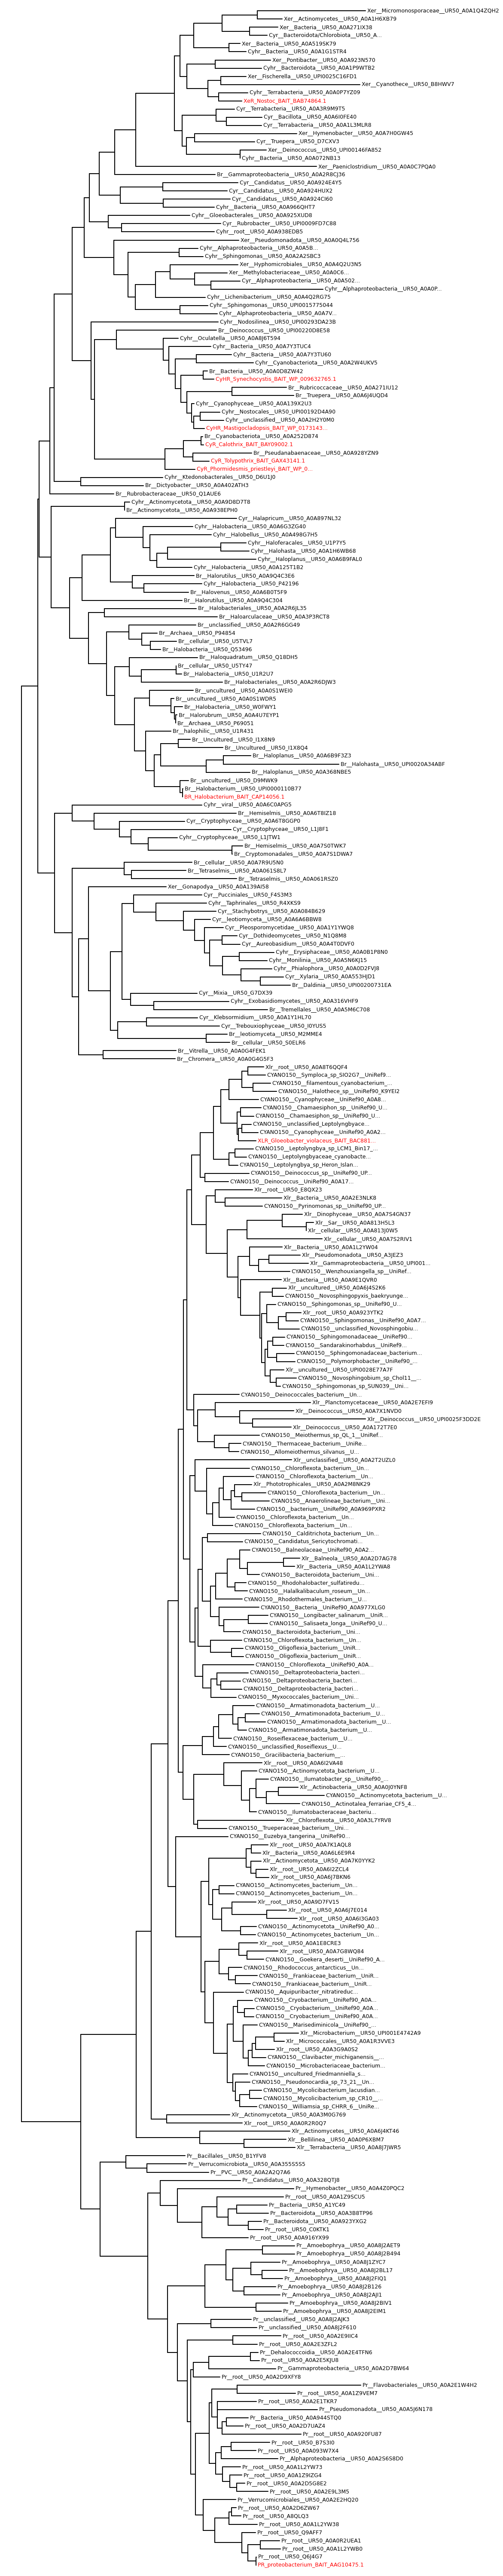

Plotted tree from ../results/trees/combined_deduped_20250827_ML_2025-08-27.treefile to ../results/figures/combined_deduped_20250827_tree.pdf


In [ ]:
import sys
sys.path.append(str(SCRIPTS))
from plot_tree import plot_tree

# Path to your specific treefile
tree_file = TREE_DIR / f"combined_deduped_{RUN_ID}_ML_{RUNID_DASH}.treefile"
fig_path = FIGURES / f"combined_deduped_{RUN_ID}_tree.pdf"

plot_tree(tree_file, save_path=fig_path, figsize=(12, 60))
print(f"Plotted tree from {tree_file} to {fig_path}")

#Original BAIT sequences in red